## Decision Tree


A decision tree is a supervised machine learning algorithm used for classification and regression tasks, where data is split into branches based on feature values to make predictions. Each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label or a continuous value. The tree is built by selecting the best feature to split the data at each step, based on criteria like Gini impurity or entropy for classification, or variance reduction for regression. Despite its simplicity and interpretability, decision trees can be prone to overfitting and sensitive to noisy data, which can be mitigated by techniques like pruning.



# Imports

In [268]:
from argparse import ArgumentParser
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

global attribute_possible_values

# Impurity Measuring Functions

## Entropy

Entropy in the context of decision trees is a measure of impurity or disorder used to determine how a dataset should be split at each node. It quantifies the uncertainty or randomness in the data. In a decision tree, entropy helps to identify the attribute that will best split the data into distinct classes.
Definition and Formula

Entropy (HH) for a binary classification problem is defined as:
H(S)=−p0log⁡2(p0)−p1log⁡2(p1)H(S)=−p0​log2​(p0​)−p1​log2​(p1​)
where:

    SS is the dataset.
    p0p0​ is the proportion of the first class in the dataset.
    p1p1​ is the proportion of the second class in the dataset.

For a multi-class classification problem, entropy is generalized to:
H(S)=−∑i=1npilog⁡2(pi)H(S)=−∑i=1n​pi​log2​(pi​)
where:

    nn is the number of classes.
    pipi​ is the proportion of instances in class ii.

### Interpretation

    High Entropy: Indicates high disorder and mixed classes. If the dataset is evenly split among different classes, entropy is high, meaning the dataset is impure.
    Low Entropy: Indicates low disorder and mostly one class. If the dataset contains instances of a single class, entropy is zero, meaning the dataset is pure.

### Using Entropy in Decision Trees

Calculate Entropy of the Entire Dataset: Measure the overall impurity before any splits.

Entropy After a Split: For each candidate attribute, calculate the weighted entropy of the resulting subsets.
H(S,A)=∑v∈values(A)∣Sv∣∣S∣H(Sv)H(S,A)=∑v∈values(A)​∣S∣∣Sv​∣​H(Sv​)
where:
SvSv​ is the subset for which attribute AA has value vv.
∣Sv∣∣S∣∣S∣∣Sv​∣​ is the proportion of subset SvSv​ relative to the original dataset SS.
Information Gain: 
Subtract the entropy after the split from the entropy before the split to find the information gain.

#### Information Gain
    
(S,A)=H(S)−H(S,A)Information Gain(S,A)=H(S)−H(S,A)
The attribute with the highest information gain is chosen for the split, as it best reduces the uncertainty.

By selecting splits that maximize information gain (or equivalently, minimize entropy), the decision tree algorithm ensures that each node split results in the most homogenous child nodes possible, leading to a more accurate and efficient classification model.

#### Most info gain 
Simply returns the biggest information gain

In [245]:
def entropy(examples, label, possible_labels):
    number_rows = examples.shape[0]
    entropy_value = 0

    for label_value in possible_labels:
        number_label_cases = examples[examples[label] == label_value].shape[0]
        label_entropy = 0
        if number_label_cases > 0:
            label_prob = number_label_cases / number_rows
            label_entropy = -(label_prob * np.log2(label_prob))
        entropy_value += label_entropy
    return round(entropy_value, 4)


def info_gain(attribute, examples, label, possible_labels):
    attr_possible_values = examples[attribute].unique()
    number_rows = examples.shape[0]
    attr_info_gain = 0.0

    for attr_value in attr_possible_values:
        attr_value_examples = examples[examples[attribute] == attr_value]
        attr_value_number_rows = attr_value_examples.shape[0]
        attr_value_entropy = entropy(attr_value_examples, label, possible_labels)
        attr_value_prob = attr_value_number_rows / number_rows
        attr_info_gain += attr_value_prob * attr_value_entropy

    return entropy(examples, label, possible_labels) - attr_info_gain

def most_info_gain(examples, label, possible_labels, possible_attributes):
    max_info_gain = -1
    max_info_attribute = None

    for attr in possible_attributes:
        attr_info_gain = info_gain(attr, examples, label, possible_labels)
        if attr_info_gain > max_info_gain:
            max_info_gain = attr_info_gain
            max_info_attribute = attr
    return max_info_attribute



Identifies the most frequently occurring label within a given set of examples. By extracting the labels from the dataset and utilizing the value_counts() method, it computes the occurrences of each unique label. Subsequently, it employs idxmax() to pinpoint the index associated with the maximum count, effectively revealing the most common label. This function is essential in decision tree algorithms for various tasks such as determining class labels for leaf nodes or guiding pruning processes based on label frequencies.

In [246]:
def most_common_label(parent_examples):

    labels = parent_examples.iloc[:, -1]
    return labels.value_counts().idxmax()


# Best Split

This function aims to find the optimal split value for a given attribute based on the information gain criterion, which is crucial for building an accurate decision tree.

In [247]:

def calculate_best_split_value(examples, attribute, label, possible_labels):
    attribute_values = sorted(examples[attribute].unique().tolist())
    best_split_value = None
    best_information_gain = float('-inf')

    middle_values = []
    for i in range(len(attribute_values) - 1):
        middle_values.append((attribute_values[i] + attribute_values[i + 1]) / 2)

    if len(attribute_values) == 1:
        # All instances have the same value for the attribute
        return attribute_values[0]

    for value in middle_values:
        less_equal = examples[examples[attribute] <= value]
        bigger = examples[examples[attribute] > value]

        q1 = len(less_equal) / len(examples)
        q2 = len(bigger) / len(examples)

        entropy1 = entropy(less_equal, label, possible_labels)
        entropy2 = entropy(bigger, label, possible_labels)

        information_gain = entropy(examples, label, possible_labels) - (q1 * entropy1) - (q2 * entropy2)

        if information_gain > best_information_gain:
            best_information_gain = information_gain
            best_split_value = value

    return round(best_split_value, 2)

# Branch Generation Functions

Generates a branch of the decision tree as a dictionary, as the attribute value
as the key and a tuple of the label value and a counter of the examples that
have that attribute value
:param parent_examples: Parent examples of the examples dataframe
:return: The resulting branch and the next examples that satisfy the branch condition

In [248]:

def generate_branch(attribute, examples, label, possible_labels, parent_examples):
    attr_values_dict = examples[attribute].value_counts(sort=False)
    global attribute_possible_values
    possible_val = attribute_possible_values[attribute]
    for value in possible_val:
        if value not in attr_values_dict.keys():
            attr_values_dict[value] = 0
    branch = {}
    next_examples = examples.copy()  # Cria uma cópia dos exemplos

    for attr_value, positives in attr_values_dict.items():
        attr_value_examples = examples[examples[attribute] == attr_value]
        isPure = False

        for label_value in possible_labels:
            label_positives = attr_value_examples[attr_value_examples[label] == label_value].shape[0]

            if label_positives == positives:
                if label_positives == 0 and positives == 0:
                    label_value = most_common_label(parent_examples)
                branch[attr_value] = (label_value, label_positives)
                next_examples = next_examples[next_examples[attribute] != attr_value]
                isPure = True

        if not isPure:
            branch[attr_value] = ('?', -1)

    if branch:
        return branch, next_examples
    else:
        return None, None

The same as the generate_branch function but with modifications to handle continuous
values. The key of the branch is a condition instead of a specific value
:return: The resulting branch and the next examples that satisfy the branch condition


In [249]:
def generate_branch_cont(attribute, examples, label, possible_labels, parent_examples):
    best_value_split = calculate_best_split_value(examples, attribute, label, possible_labels)
    less_equal = examples[examples[attribute] <= best_value_split]
    bigger = examples[examples[attribute] > best_value_split]

    next_examples = examples.copy()
    branch = {}

    isPure = False
    for label_value in possible_labels:
        label_positives = less_equal[less_equal[label] == label_value].shape[0]
        count = less_equal.shape[0]

        if label_positives == count:
            if label_positives == 0 and count == 0:
                label_value = most_common_label(parent_examples)
            branch[f"<= {best_value_split}"] = (label_value, label_positives)
            next_examples = next_examples[next_examples[attribute] > best_value_split]
            isPure = True

    if not isPure:
        branch[f"<= {best_value_split}"] = ('?', -1)

    isPure = False
    for label_value in possible_labels:
        label_positives = bigger[bigger[label] == label_value].shape[0]
        count = bigger.shape[0]

        if label_positives == count:
            if label_positives == 0 and count == 0:
                label_value = most_common_label(parent_examples)
            branch[f"> {best_value_split}"] = (label_value, label_positives)
            next_examples = next_examples[next_examples[attribute] <= best_value_split]
            isPure = True

    if not isPure:
        branch[f"> {best_value_split}"] = ('?', -1)

    if branch:
        return branch, next_examples, best_value_split
    else:
        return None, None, None

# TREES

#### Transverse Tree function

The transverse_tree function is used to make predictions using the decision tree generated by your ID3 algorithm (which will be further explained in the notebook). It is a critical part of our classifier, as it takes a decision tree and a data row from your test dataset and outputs a predicted label for that row.

In [250]:
def transverse_tree(tree, row):
    for attr, subtree in tree.items():
        value = row[attr]
        if isinstance(subtree, dict):

            if isinstance(value, str):
                if value in subtree:
                    subtree = subtree[value]
            else:
                split_operator, split_value = list(subtree.keys())[0].split()
                if split_operator == '<=':
                    if value <= float(split_value):
                        subtree = subtree['<= ' + split_value]
                    else:
                        subtree = subtree['> ' + split_value]
                else:
                    if value > float(split_value):
                        subtree = subtree['> ' + split_value]
                    else:
                        subtree = subtree['<= ' + split_value]

            if isinstance(subtree, dict):
                return transverse_tree(subtree, row)
            else:
                return subtree[0]
        else:
            return subtree[0]

### Build Tree Function

The build_tree function constructs the decision tree by recursively splitting the dataset based on the attribute that maximizes information gain at each step. It handles both categorical and continuous data and dynamically builds a complex tree structure represented as nested dictionaries. Each node in the dictionary represents a decision point in the tree, directing to either another decision or a final label based on the attributes of the data being classified.


In [251]:
def build_tree(root, previous_attr_value, examples, label, possible_labels, parent_examples, possible_attributes):
    if examples.shape[0] != 0:
        if not possible_attributes.any():
            label_value = most_common_label(parent_examples)
            root[previous_attr_value] = (label_value, examples.shape[0])
            return
        max_info_attr = most_info_gain(examples, label, possible_labels, possible_attributes)
        remaining_attr = possible_attributes.drop(max_info_attr)
        split_value = None
        if examples[max_info_attr].dtype == 'object':
            tree, next_examples = generate_branch(max_info_attr, examples, label, possible_labels, parent_examples)
            flag = False
        else:
            tree, next_examples, split_value = generate_branch_cont(max_info_attr, examples, label, possible_labels,
                                                                    parent_examples)
            flag = True

        if previous_attr_value is not None:
            root[previous_attr_value] = {}
            root[previous_attr_value][max_info_attr] = tree
            next_node = root[previous_attr_value][max_info_attr]
        else:
            root[max_info_attr] = tree
            next_node = root[max_info_attr]

        for node, branch in list(next_node.items()):
            if branch[0] == '?':
                if flag:
                    if '<=' in node:
                        attr_value_examples = next_examples[next_examples[max_info_attr] <= split_value]
                    else:
                        attr_value_examples = next_examples[next_examples[max_info_attr] > split_value]
                else:
                    attr_value_examples = next_examples[next_examples[max_info_attr] == node]
                build_tree(next_node, node, attr_value_examples, label, possible_labels, examples, remaining_attr)

### Print Tree Function

The print_tree function is designed to visually represent the decision tree constructed by the ID3 algorithm. It outputs the structure of the tree to the console, using indentation to indicate the depth and hierarchy of the decision nodes and their respective outcomes. This makes it easier to understand how decisions are made within the tree.

In [252]:
def print_tree(tree, indent=''):
    """
    Recursive function to print the decision tree
    :param tree: Decision tree as a dicionary
    :param indent: Indent of each line that is updated recursively
    """
    if isinstance(tree, dict):
        for key, value in tree.items():
            if isinstance(value, dict):
                print(f'{indent}{key}:')
                print_tree(value, indent + '  ')
            else:
                print(f'{indent}{key}: {value[0]}  ({value[1]})')

# ID3

The ID3 function sets up and begins the process of building a decision tree using the ID3 algorithm. It prepares the necessary parameters and data structures and delegates the complex task of iteratively constructing the tree to the build_tree function. This separation of concerns allows ID3 to focus on initialization and setup, while build_tree handles the algorithmic complexity of creating the tree structure.

The output decision tree is a dictionary that can be used for predicting labels of new data instances by traversing it based on the attributes and their values found in the new data. This makes the ID3 function critical for both learning from the training data and preparing the model for future predictions.

In [253]:
def ID3(data, label):
    """
    Initialize the ID3 algorithm to build the decision tree
    :param data: Training DataFrame
    :param label: Label name
    :return: The decision tree
    """
    training_data = data.copy()
    tree = {}
    possible_labels = training_data[label].unique()
    id_name = training_data.columns[0]
    possible_attributes = training_data.columns.drop([label, id_name])
    build_tree(tree, None, training_data, label, possible_labels, training_data, possible_attributes)
    return tree


# Tree and Metrics utiities

In [254]:
def train_test_split(data, test_size=0.2):
    data = data.sample(frac=1).reset_index(drop=True)  # Shuffle the data
    split_index = int(len(data) * (1 - test_size))
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data

def calculate_accuracy(tree, test_data, label):
    correct_predictions = 0
    predictions = []
    for index, row in test_data.iterrows():
        prediction = transverse_tree(tree, row)
        predictions.append(prediction)
        if prediction == row[label]:
            correct_predictions += 1

    accuracy = correct_predictions / len(test_data)
    return accuracy, predictions

def generate_tree(dataset):
    data = pd.read_csv(dataset)
    attribute_possible_values = {}
    for collumn in data.columns:
        attribute_possible_values[collumn] = data[collumn].unique()
    label  = data.columns[-1]
    tree = ID3(data, label)
    print_tree(tree)
    return tree

def generate_split_tree(dataset):
    data= pd.read_csv(dataset)
    attribute_possible_values = {}
    
    for collumn in data.columns:
        attribute_possible_values[collumn] = data[collumn].unique()
    
    train_data, test_data = train_test_split(data)
    label  = data.columns[-1]
    
    tree = ID3(train_data, label)
    
    print_tree(tree)
    
    accuracy, predictions = calculate_accuracy(tree, test_data, label)
    
    print(f'Predictions: {predictions}\n\n Accuracy: {accuracy}')

def test_prev_tree(dataset, tree):
    data = pd.read_csv(dataset)
    label  = data.columns[-1]
    accuracy, predictions = calculate_accuracy(tree, data, label)
    print(f'Predictions: {predictions}\n\n Accuracy: {accuracy}')


# Tree comparison (without and with split)

### Restaurant Dataset


In [255]:
restaurant_tree = generate_tree('restaurant.csv')

Pat:
  Some: Yes  (4)
  Full:
    Hun:
      Yes:
        Type:
          Thai:
            Fri:
              No: No  (1)
              Yes: Yes  (1)
          Italian: No  (1)
          Burger: Yes  (1)
          French: No  (0)
      No: No  (2)
  nan: Yes  (0)


In [256]:
generate_split_tree('restaurant.csv')

Pat:
  Full:
    Type:
      Italian: No  (1)
      Thai: Yes  (1)
      Burger: No  (1)
      French: No  (1)
  Some: Yes  (3)
  nan: No  (0)
Predictions: ['No', 'Yes', 'Yes']

 Accuracy: 0.3333333333333333


### Iris Dataset

In [257]:
iris_tree = generate_tree('iris.csv')

petallength:
  <= 2.45: Iris-setosa  (50)
  > 2.45:
    petalwidth:
      <= 1.75:
        sepallength:
          <= 7.1:
            sepalwidth:
              <= 2.85: Iris-versicolor  (31)
              > 2.85: Iris-versicolor  (22)
          > 7.1: Iris-virginica  (1)
      > 1.75:
        sepallength:
          <= 5.95:
            sepalwidth:
              <= 3.1: Iris-virginica  (6)
              > 3.1: Iris-versicolor  (1)
          > 5.95: Iris-virginica  (39)


In [258]:
generate_split_tree('iris.csv')

petallength:
  <= 2.45: Iris-setosa  (45)
  > 2.45:
    petalwidth:
      <= 1.75:
        sepalwidth:
          <= 2.85:
            sepallength:
              <= 5.9: Iris-versicolor  (13)
              > 5.9: Iris-versicolor  (9)
          > 2.85: Iris-versicolor  (21)
      > 1.75:
        sepallength:
          <= 5.95:
            sepalwidth:
              <= 3.1: Iris-virginica  (6)
              > 3.1: Iris-versicolor  (1)
          > 5.95: Iris-virginica  (25)
Predictions: ['Iris-versicolor', 'Iris-virginica', 'Iris-virginica', 'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica', 'Iris-setosa', 'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica', 'Iris-virginica', 'Iris-setosa', 'Iris-virginica', 'Iris-virginica', 'Iris-setosa', 'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica', 'Iris-virginica', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica', 'Iris-virginica', 'Iris-virginica', 'Iris-versicolor', 'Iris-versicol

### Weather Dataset

In [262]:
weather_tree = generate_tree('weather.csv')

Temp:
  <= 84.0:
    Humidity:
      <= 88.0:
        Weather:
          overcast: yes  (3)
          rainy:
            Windy:
              <= 0.5: yes  (2)
              > 0.5: no  (1)
          sunny: yes  (2)
      > 88.0:
        Weather:
          sunny: no  (2)
          rainy:
            Windy:
              <= 0.5: yes  (1)
              > 0.5: no  (1)
          overcast: yes  (1)
  > 84.0: no  (1)


In [263]:
generate_split_tree('weather.csv')

Temp:
  <= 73.5:
    Humidity:
      <= 67.5: yes  (1)
      > 67.5:
        Weather:
          rainy:
            Windy:
              <= 0.5: yes  (2)
              > 0.5: no  (2)
          sunny: no  (1)
          overcast: yes  (1)
  > 73.5: yes  (4)
Predictions: ['no', 'yes', 'yes']

 Accuracy: 0.0


### Connect4 Dataset

We decided not to print the connect4 tree on the notebook, as it was really extensive. Instead on the zip project folder you can find a txt file with the connect4 tree.

The implementation of the connect4 dataset is different since the generate_tree function printed the tree and we didn't want that for this dataset

In [267]:
data = pd.read_csv('connect4.csv')
attribute_possible_values = {}
for collumn in data.columns:
    attribute_possible_values[collumn] = data[collumn].unique()
label  = data.columns[-1]
connect4_tree = ID3(data, label)

In [ ]:
data= pd.read_csv('connect4.csv')
attribute_possible_values = {}

for collumn in data.columns:
    attribute_possible_values[collumn] = data[collumn].unique()

train_data, test_data = train_test_split(data)
label  = data.columns[-1]

tree = ID3(train_data, label)

accuracy, predictions = calculate_accuracy(tree, test_data, label)

print(f'Predictions: {predictions}\n\n Accuracy: {accuracy}')

# Test with new data

Here you can test a previously generated tree and predict the target results of a new data set of the same kind

To test that you simply have to run this line:

```
test_prev_tree(dataset, tree)
```

And replace 'dataset' with the new dataset you want to predict and 'tree' with one of the trees above ```(restaurant_tree; iris_tree; weather_tree; connect4_tree)``` 


# Accuracy Plots and final remarks

### Tests with x iterations on the datasets

In [285]:
def predict_csv(path):
    data = pd.read_csv(path)

    for collumn in data.columns:
        attribute_possible_values[collumn] = data[collumn].unique()
    
    train_data, test_data = train_test_split(data)
    label  = data.columns[-1]
    
    tree = ID3(train_data, label)
    
    accuracy, predictions = calculate_accuracy(tree, test_data, label)
    
    return accuracy


def test(dataset, i):
    j=1
    accuracy_values = []
    accuracies= 0.0
    accuracy= 0
    while j <= i:
        try:
            accuracy = float(predict_csv(dataset))
        except: 
            j= 1
            accuracies = 0.0
            accuracy_values.clear()
        finally:
            j+=1
            accuracies += accuracy
            accuracy_values.append(accuracy)
    
    print(f'Average Accuracy: {sum(accuracy_values)/i}')
    return accuracy_values, accuracy


### Accuracy Plot Function

In [286]:
def plot_accuracies(accuracy_values):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', linestyle='-', color='b')
    plt.title('Model Accuracy Over Multiple Runs')
    plt.xlabel('Run Number') 
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(range(1, len(accuracy_values) + 1))
    plt.ylim([0, 1])
    plt.show()


### Restaurant Dataset

Average Accuracy: 0.5333333333333333


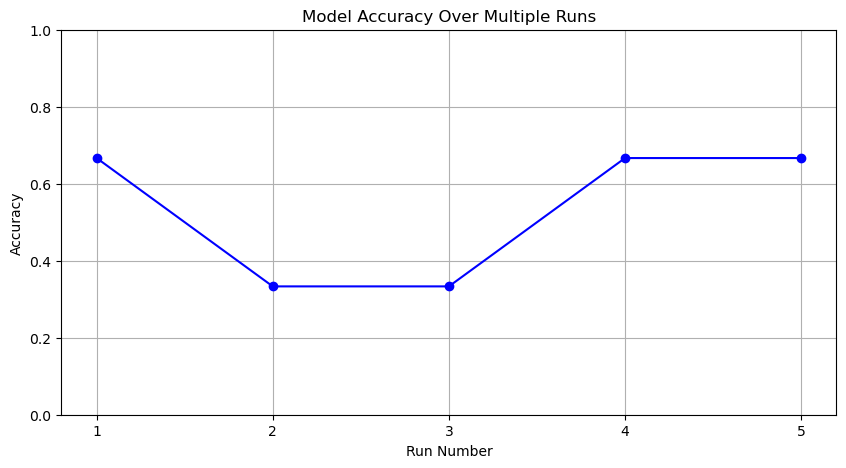

In [288]:
accuracy_values, _ = test('restaurant.csv', 5)
plot_accuracies(accuracy_values)

### Iris Dataset

Average Accuracy: 0.9066666666666666


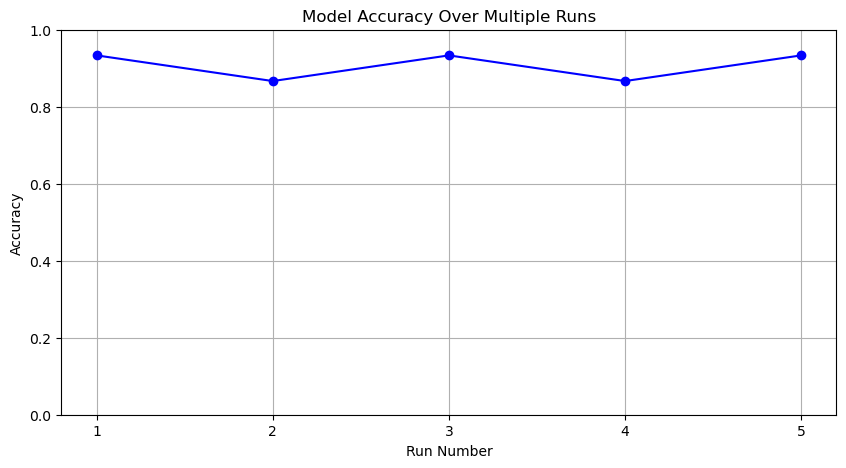

In [294]:
accuracy_values, _ = test('iris.csv', 5)
plot_accuracies(accuracy_values)

### Weather Dataset

Average Accuracy: 0.4666666666666666


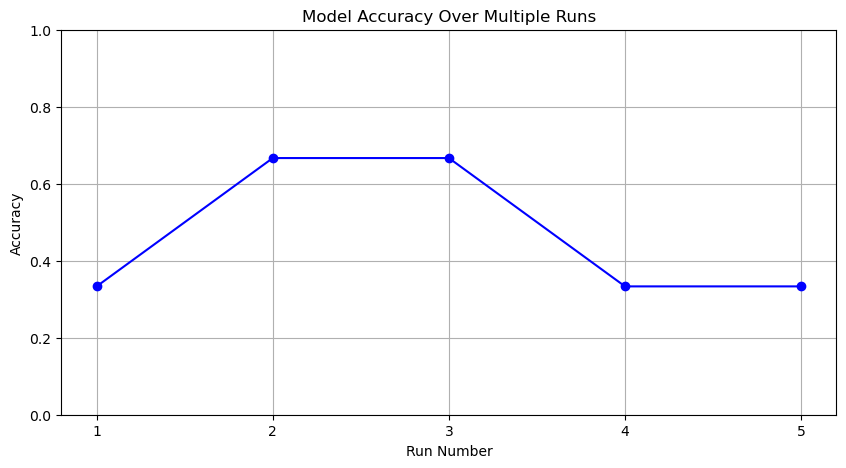

In [298]:
accuracy_values, _ = test('weather.csv', 5)
plot_accuracies(accuracy_values)

### Connect4 Dataset

Average Accuracy: 0.7517021906453523


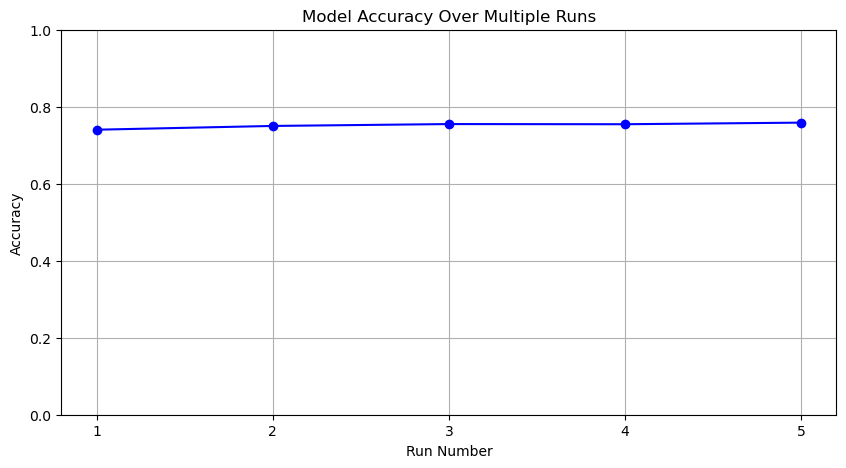

In [301]:
accuracy_values, _ = test('connect4.csv', 5)
plot_accuracies(accuracy_values)

## Accuracy Overview

As you can see the plot functions range between a few values over the iterations on every dataset.

Although it seems our accuracy is very low for example on the restaurant dataset and the weather dataset this is due to the csv files having little to no data.

For example the iris or connect4 dataset which have much more data have a good accuracy.